In [18]:
import os, glob, random
from collections import Counter

import numpy as np
import pandas as pd

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [19]:
INPUT_DIR = "/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes"
img_exts = (".jpg",".jpeg",".png")

all_imgs, all_xmls, all_txts = [], [], []
for root, _, files in os.walk(INPUT_DIR):
    for f in files:
        fp = os.path.join(root, f)
        if f.lower().endswith(img_exts):
            all_imgs.append(fp)
        elif f.lower().endswith(".xml"):
            all_xmls.append(fp)
        elif f.lower().endswith(".txt"):
            all_txts.append(fp)

print("Images:", len(all_imgs))
print("XMLs  :", len(all_xmls))
print("TXTs  :", len(all_txts))
print("Example image:", all_imgs[0] if all_imgs else None)
print("Example xml  :", all_xmls[0] if all_xmls else None)
print("Example txt  :", all_txts[0] if all_txts else None)

Images: 1300
XMLs  : 0
TXTs  : 1301
Example image: /kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_7209.jpeg
Example xml  : None
Example txt  : /kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/classes.txt


In [20]:
def find_image_by_stem(stem):
    hits = []
    for ext in img_exts:
        hits += glob.glob(os.path.join(INPUT_DIR, "**", stem + ext), recursive=True)
    return hits[0] if hits else None

df = None

# --- Try VOC XML first ---
if len(all_xmls) > 0:
    import xml.etree.ElementTree as ET
    
    def find_image_by_filename(fn):
        hits = glob.glob(os.path.join(INPUT_DIR, "**", fn), recursive=True)
        return hits[0] if hits else None

    def parse_voc_xml(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.findtext("filename")
        size = root.find("size")
        width = int(size.findtext("width"))
        height = int(size.findtext("height"))

        rows = []
        for obj in root.findall("object"):
            label = obj.findtext("name").strip()
            bnd = obj.find("bndbox")
            xmin = int(float(bnd.findtext("xmin")))
            ymin = int(float(bnd.findtext("ymin")))
            xmax = int(float(bnd.findtext("xmax")))
            ymax = int(float(bnd.findtext("ymax")))

            rows.append({
                "ann_format": "voc_xml",
                "ann_path": xml_path,
                "filename": filename,
                "img_path": find_image_by_filename(filename),
                "width": width, "height": height,
                "label": label,
                "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax
            })
        return rows

    rows = []
    for x in all_xmls:
        try:
            rows.extend(parse_voc_xml(x))
        except:
            pass

    df = pd.DataFrame(rows)
    print("Built df from XML. Rows:", len(df))

# --- Else, try YOLO txt ---
if (df is None or len(df) == 0) and len(all_txts) > 0:
    def is_yolo_file(txt_path):
        try:
            with open(txt_path, "r") as f:
                lines = [l.strip() for l in f.readlines() if l.strip()]
            if len(lines) == 0:
                return False
            return len(lines[0].split()) == 5
        except:
            return False

    yolo_txts = [t for t in all_txts if is_yolo_file(t)]
    print("YOLO-like txt files:", len(yolo_txts))

    def parse_yolo_txt(txt_path):
        stem = os.path.splitext(os.path.basename(txt_path))[0]
        img_path = find_image_by_stem(stem)
        if img_path is None:
            return []

        img = Image.open(img_path)
        W, H = img.size

        rows = []
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cid, xc, yc, w, h = parts
                cid = int(float(cid))
                xc, yc, w, h = map(float, [xc, yc, w, h])

                xmin = int((xc - w/2) * W)
                ymin = int((yc - h/2) * H)
                xmax = int((xc + w/2) * W)
                ymax = int((yc + h/2) * H)

                rows.append({
                    "ann_format": "yolo_txt",
                    "ann_path": txt_path,
                    "img_path": img_path,
                    "width": W, "height": H,
                    "label": str(cid),
                    "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax
                })
        return rows

    rows = []
    for t in yolo_txts:
        try:
            rows.extend(parse_yolo_txt(t))
        except:
            pass

    df = pd.DataFrame(rows)
    print("Built df from YOLO TXT. Rows:", len(df))

if df is None or len(df) == 0:
    raise ValueError("No usable XML/YOLO annotations found.")

df = df.dropna(subset=["img_path"]).reset_index(drop=True)
print("Final df rows:", len(df))
print("Columns:", df.columns.tolist())
df.head()


YOLO-like txt files: 1300
Built df from YOLO TXT. Rows: 2072
Final df rows: 2072
Columns: ['ann_format', 'ann_path', 'img_path', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']


,ann_format,ann_path,img_path,width,height,label,xmin,ymin,xmax,ymax
0,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,0,16,200,497,423
1,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,1,157,148,464,437
2,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,0,48,0,512,502
3,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,1,88,107,444,394
4,yolo_txt,/kaggle/input/crop-and-weed-detection-data-wit...,/kaggle/input/crop-and-weed-detection-data-wit...,512,512,1,108,123,392,312


Total boxes: 2072
Unique label files: 1300
Unique images: 1300
Unique labels: 2
Labels: ['0' '1']


0    1212
1     860
Name: label, dtype: int64

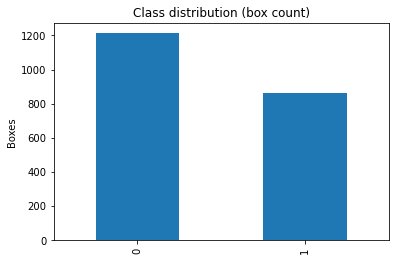

In [23]:
print("Total boxes:", len(df))
print("Unique label files:", df["ann_path"].nunique())
print("Unique images:", df["img_path"].nunique())
print("Unique labels:", df["label"].nunique())
print("Labels:", df["label"].unique())

label_counts = df["label"].value_counts()
display(label_counts)

plt.figure()
label_counts.plot(kind="bar")
plt.title("Class distribution (box count)")
plt.ylabel("Boxes")
plt.show()

count    1300.000000
mean        1.593846
std         1.950020
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        19.000000
dtype: float64

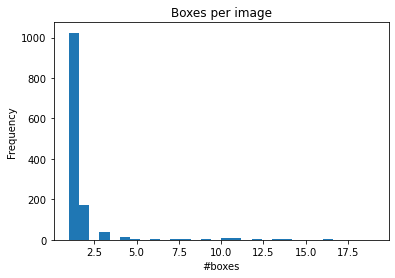

In [24]:
boxes_per_image = df.groupby("img_path").size()
display(boxes_per_image.describe())

plt.figure()
boxes_per_image.plot(kind="hist", bins=30)
plt.title("Boxes per image")
plt.xlabel("#boxes")
plt.show()